In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models

## Problem Description

This project uses deep learning to classify tweets based on if they are about real disasters. This is a Kaggle competition at https://www.kaggle.com/competitions/nlp-getting-started. The focus is on testing out recurrent neural networks (RNNs) to perform this classification.

We will utilize natural language processing (NLP), a field of computer science that focuses on how computing technology can work with "natural language," language that occurs naturally with humans. In this scenario, we are looking at a subset of tweets that are written in English and are illustrative of how people communicate in a natural manner with the English language. The "natural" aspect speaks to how people actually use the language rather than just focusing on the formal ways in which people are supposed to use the language. The RNNs we will test out require numbers as inputs, so our use of NLP will include converting written text into numeric representation as well as capturing relationships and context within the language. 

We will need the context abilities of RNNs since the use of disaster-related words on their own may not indicate an actual disaster. For example, someone may tweet "This is a disaster," using the literal word "disaster" but referring metaphorically to a situation that is not a disaster that, for instance, a disaster relief group needs to respond to.

After building the models, the competition asks us to submit files with target labels for the test set to evaluate and compare with other submissions based on F1 score.

## Data Description & Initial Preprocessing

In [7]:
in_dir = '/kaggle/input/disaster-tweet-raw-data'
out_dir = '/kaggle/working'

df_train = pd.read_csv(f'{in_dir}/train.csv')
df_test = pd.read_csv(f'{in_dir}/test.csv')
# df_sample_submission = pd.read_csv('./data/sample_submission.csv')
# df_sample_submission.head()

In [3]:
print(f'The training set has {df_train.shape[0]:,} rows and {df_train.shape[1]} columns')
print(f'The test set has {df_test.shape[0]:,} rows and {df_test.shape[1]} columns')
df_train.head()

The training set has 7,613 rows and 5 columns
The test set has 3,263 rows and 4 columns


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The dataset has three features we will be working with:
- id: unique identifier that we will drop
- keyword: a keyword from the tweet and can be null
- location: location from where the tweet was send and can be null
- text: the body of a tweet
- target: 1 if the tweet is an actual disaster and 0 if it is not

Note: I initially built out modeling to incorporate multiple input features, but I pivoted to only including `text` for this iteration. I want to keep the preprocessing and EDA code for the other features though since the next pass on the project should incorporate those.

First we check the overall size and shape of the data we are working with. The sample submission file in the end will need one row per `id` and `target` label, so nothing fancy. We also want to see if there are duplicates in the training set. The initial thought is that we will want to remove any rows that are duplicated across all columns except for `id` so that the modeling is not favoring identical rows that show up more than once.

The default for the `keep` param for `duplicated()` is first, meaning that the first instance of a duplicated row is flagged as valid and the remaining duplicated rows show up here. We want to keep one of each duplicated row, so the default for `keep` is good.

In [8]:
# Check if any rows are duplicated across all features
print(f'There are {df_train[df_train.duplicated()].shape[0]} rows duplicated across all features, including the id feature')

# Check if any ids are duplicated
print(f"There are {df_train[df_train.duplicated(subset='id')].shape[0]} duplicated ids")

# Check if any rows are duplicated just in the text feature
print(f"There are {df_train[df_train.duplicated(subset='text')].shape[0]} rows duplicated across the text feature")

# Check if any rows are duplicated across the keyword, location, and text features. 
print(f'There are '
    f"{df_train[df_train.duplicated(subset=['keyword', 'location', 'text'])].shape[0]} "
    f'rows duplicated across the keyword, location, text features'
)

# Drop duplicate rows
df_train.drop_duplicates(
    subset=[
#         'keyword'
#         , 'location'
        'text'
    ], inplace=True
)
print(f'We end up with {df_train.shape[0]:,} rows remaining after dropping duplicates')
print()

print(f"Test: there are {df_test[df_test.duplicated(subset='id')].shape[0]} duplicated ids")

There are 0 rows duplicated across all features, including the id feature
There are 0 duplicated ids
There are 110 rows duplicated across the text feature
There are 61 rows duplicated across the keyword, location, text features
We end up with 7,503 rows remaining after dropping duplicates

Test: there are 0 duplicated ids


We see 110 rows duplicated across the text feature and 61 rows that are duplicated across all features except the primary key id feature. This is 1.5% and 0.8% out of the 7,613 total rows respectively, so we can drop them without losing too much data. For this iteration of the project, we will drop rows duplicated across only the text feature.

Next we need to clean up bad characters. We see some characters that do not look like they were encoded correctly in the original CSV. Originally I planned to focus only on American Standard Code for Information Interchange (ASCII) text, but there is about 10% of the rows in the test set with non-ASCII characters. We have a couple of strategies here.

- We cannot drop rows from the test set because we need them for the competition submission. That said, we could drop rows with non-ASCII characters from the train set and let the model do what it will with the test rows for this iteration, knowing we will return to patch this piece up in future iterations.
- We can remove all non-ASCII characters or convert them to a standard character such as a blank space. This is a pretty crude approach, but it keeps more rows in the train set, and it removes characters we might be worried about in the test set.
- We can broaden our check from ASCII to UTF-8 encoding, but the CSV file is already encoded in UTF-8, and the characters that look like invalid encodings are not easy to identify. I played around with different regex patterns, and I was not able to isolate what I am seeing as bad characters. (See next code block for an example where I think the encoding got mucked up.)

We will go with the option of removing non-ASCII characters, admitting that this might lose us too much information for valid characters in tweets as well as handling invalid characters.

In future iterations, this is something to return to with a more complicated strategy for cleaning up these characters, in particular finding a way to distinguish between valid non-ASCII characters and characters with botched encodings.

In [18]:
# Example row with non-ASCII characters
df_train[df_train['id'] == 3373]

,id,keyword,location,text,target
2345,3373,demolition,NaN,General News Û¢åÊ'Demolition of houses on wat...,0


In [26]:
regex = r'[^\x00-\x7F]'

# Check for non-ASCII chars in keyword feature -- note that we return 0 for this
print(f"Train: rows where keyword feature has non-ASCII characters: {df_train[df_train['keyword'].str.contains(regex, na=False)].shape[0]}")
print(f"Test:  rows where keyword feature has non-ASCII characters: {df_test[df_test['keyword'].str.contains(regex, na=False)].shape[0]}")
print()

# Check for non-ASCII chars in location feature
print(f"Train: rows where location feature has non-ASCII characters: {df_train[df_train['location'].str.contains(regex, na=False)].shape[0]}")
print(f"Test:  rows where location feature has non-ASCII characters: {df_test[df_test['location'].str.contains(regex, na=False)].shape[0]}")
print()

# Check for non-ASCII chars in text feature
print(f"Train: rows where text feature has non-ASCII characters: {df_train[df_train['text'].str.contains(regex)].shape[0]}")
print(f"Test:  rows where text feature has non-ASCII characters: {df_test[df_test['text'].str.contains(regex)].shape[0]}")
print()

# Check for non-ASCII chars in location or feature
print(f'Train: rows where location or text feature has non-ASCII characters: '
    f"{df_train[df_train['text'].str.contains(regex) | df_train['location'].str.contains(regex, na=False)].shape[0]}"
)
print(f'Test:  rows where location or text feature has non-ASCII characters: '
      f"{df_test[df_test['text'].str.contains(regex) | df_test['location'].str.contains(regex, na=False)].shape[0]}"
)
print()

# Drop rows that have non-ASCII characters in location or text features
df_train['text_ascii'] = df_train['text'].str.encode('ascii', errors='ignore').str.decode('ascii')
df_test['text_ascii'] = df_test['text'].str.encode('ascii', errors='ignore').str.decode('ascii')

Train: rows where keyword feature has non-ASCII characters: 0
Test:  rows where keyword feature has non-ASCII characters: 0

Train: rows where location feature has non-ASCII characters: 105
Test:  rows where location feature has non-ASCII characters: 35

Train: rows where text feature has non-ASCII characters: 677
Test:  rows where text feature has non-ASCII characters: 331

Train: rows where location or text feature has non-ASCII characters: 774
Test:  rows where location or text feature has non-ASCII characters: 362



The final cleanup step before jumping into EDA and further preprocessing is to handle missing values since the models in a bit do not play nice with nulls. For this iteration, we will not drop any rows, but this is a step to look at again in a future iteration when incorporating other features into the model.

As we see in the next code block, there are 56 rows with null keyword values, and there are 2,482 rows with null locations. 56 is probably small enough for us to drop at this point, but 2,482 is too many to lose. Unfortunately, the missing keywords do not overlap with missing locations.

We will manually scan through the rows with missing values for the location feature to see if any patterns pop out. If we are able to find an informed strategy, we might be able to leverage something smarter for imputing values.

In [29]:
print('train:')
print(df_train.isna().sum())
print()
print('test:')
print(df_test.isna().sum())
print()
df_train.dropna(subset='keyword').isna().sum()
df_test.dropna(subset='keyword').isna().sum()

# df_train.dropna(
#     subset='keyword'
#     , inplace=True
# )

train:
id               0
keyword         56
location      2482
text             0
target           0
text_ascii       0
dtype: int64

test:
id               0
keyword         26
location      1105
text             0
text_ascii       0
dtype: int64



id               0
keyword          0
location      1079
text             0
text_ascii       0
dtype: int64

In [30]:
df_train[df_train.isna().any(axis=1)].sample(100)

,id,keyword,location,text,target,text_ascii
5529,7887,quarantined,NaN,Ebola: Alabama Home Quarantined Over Possible ...,1,Ebola: Alabama Home Quarantined Over Possible ...
2697,3869,detonation,NaN,New SMP Ignition Knock (Detonation) Sensor KS3...,0,New SMP Ignition Knock (Detonation) Sensor KS3...
1848,2658,crush,NaN,This guy idk just made me his woman crush ?? f...,0,This guy idk just made me his woman crush ?? f...
7501,10730,wreck,NaN,@TitorTau The Loretta Lynch one was fuckin' HI...,0,@TitorTau The Loretta Lynch one was fuckin' HI...
6192,8839,sirens,NaN,sleeping with sirens vai vir pra sp,0,sleeping with sirens vai vir pra sp
...,...,...,...,...,...,...
5752,8212,riot,NaN,@AcaciaPenn I'll start a big ass riot send me...,0,@AcaciaPenn I'll start a big ass riot send me...
1170,1687,bridge%20collapse,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...
6944,9960,tsunami,NaN,So did we have a hurricane tornado tsunami? So...,1,So did we have a hurricane tornado tsunami? So...
135,195,aftershock,NaN,Anyone need a P/U tonight? I play Hybrid Slaye...,0,Anyone need a P/U tonight? I play Hybrid Slaye...


Unfortunately, there does not appear to be a pattern in how locations are missing. My original strategy was to keep location in the modeling and impute "nope" for rows that are missing location, also adding a boolean flag indicating if we imputed location so the model can have that as an extra input. But we will leave this alone for this iteration.

In [9]:
# Note that this cell is not idempotent
# df_train['is_location_imputed'] = df_train['location'].isna().astype(int)
# df_train['location_imputed'] = df_train['location'].fillna('nope')

# df_test['is_location_imputed'] = df_test['location'].isna().astype(int)
# df_test['location_imputed'] = df_test['location'].fillna('nope')

### Exploratory Data Analysis (EDA)

We will start EDA by looking at what we are working with in the keyword and location features. The next code block shows that we have the same keywords in the train and test sets. The locations are a bit of a mess. We will look at those in a minute.

In [32]:
def train_test_diffs(s1, s2):
    diff1 = set(s1).difference(set(s2))
    diff2 = set(s2).difference(set(s1))

    return diff1, diff2

In [33]:
print(f"Train: number of unique keywords: {df_train['keyword'].nunique(dropna=False)}")
print(f"Test:  number of unique keywords: {df_test['keyword'].nunique(dropna=False)}")
print(f"Keywords in one dataset and not the other for (train, test): {train_test_diffs(df_train['keyword'], df_test['keyword'])}")

Train: number of unique keywords: 222
Test:  number of unique keywords: 222
Keywords in one dataset and not the other for (train, test): (set(), set())


In [34]:
df_train['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
damage                   41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [39]:
# Note that this is not idempotent
print(f"Train: number of rows with URI percent encoding other than %20: {df_train[df_train['keyword'].str.contains('%') & ~(df_train['keyword'].str.contains('%20', na=False))].shape[0]}")
print(f"Test:  number of rows with URI percent encoding other than %20: {df_test[df_test['keyword'].str.contains('%') & ~df_test['keyword'].str.contains('%20', na=False)].shape[0]}")

df_train['keyword_clean'] = df_train['keyword'].str.replace('%20', ' ')
df_test['keyword_clean'] = df_test['keyword'].str.replace('%20', ' ')

Train: number of rows with URI percent encoding other than %20: 0
Test:  number of rows with URI percent encoding other than %20: 0


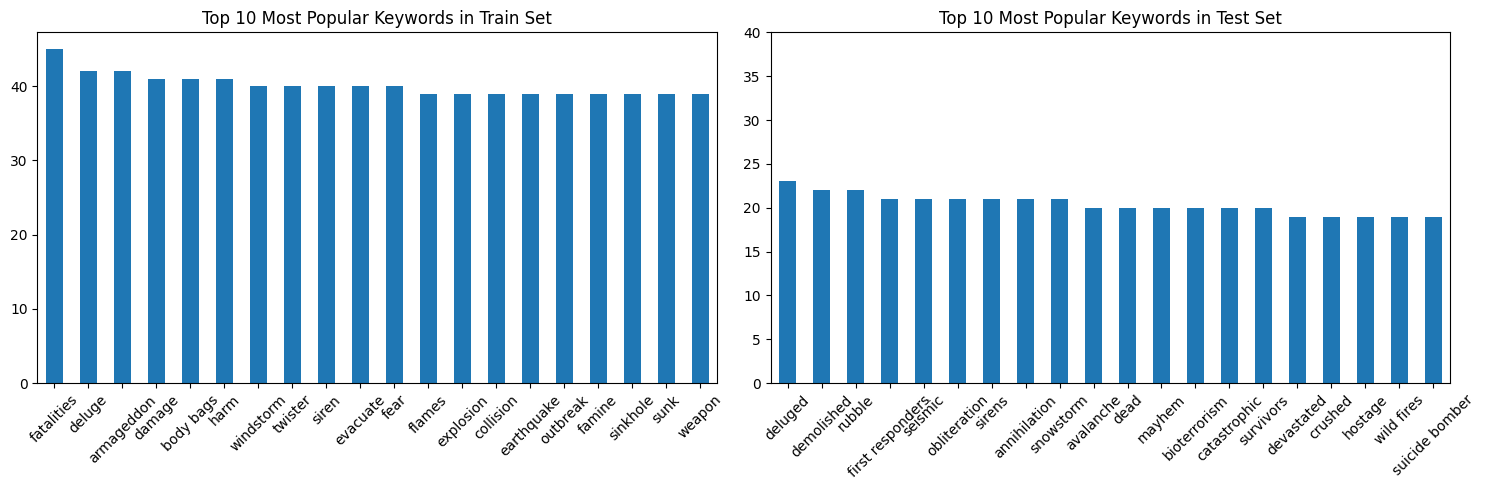

In [40]:
fig, axes = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(15, 5)
)

df_train['keyword_clean'].value_counts().head(20).plot(
    kind='bar'
    , ax=axes[0]
    , rot=45
);
axes[0].set_title('Top 10 Most Popular Keywords in Train Set')
axes[0].set_xlabel(None)


df_test['keyword_clean'].value_counts().head(20).plot(
    kind='bar'
    , ax=axes[1]
    , rot=45
);
axes[1].set_title('Top 10 Most Popular Keywords in Test Set')
# Manually set y-axis limits for second plot for relative comparison
axes[1].set_ylim([0, 40])
axes[1].set_xlabel(None)

plt.tight_layout()

The only thing that stands out with the keywords is that they still have uniform resource identifier (URI) percent encoding for spaces as %20s. That is an easy find-and-replace.

We then check out the 10 most common keywords in the train and test sets, mostly looking to see if the same keywords show up in each. Interestingly, they do not overlap. I was expecting them to. This could be chance, or it could be that we have a curated test set where the common values purposely do not match. Either way, this will not change our approach to modeling later.

Next, we will figure out what to do with the location feature.

In [41]:
print(f"Train: number of unique locations: {df_train['location'].nunique(dropna=False):,}")
print(f"Test:  number of unique locations: {df_test['location'].nunique(dropna=False):,}")
print()

in_train_not_test, in_test_not_train = train_test_diffs(df_train['location'], df_test['location'])
print(f'Number of unique locations in train but not test: {len(in_train_not_test):,}')
print(f'Number of unique locations in test but not train: {len(in_test_not_train):,}')

# Just for kicks
df_train['location'].value_counts().sample(100, random_state=8675309)
# df_test['location'].value_counts().sample(100, random_state=8675309)

Train: number of unique locations: 3,328
Test:  number of unique locations: 1,603

Number of unique locations in train but not test: 2,906
Number of unique locations in test but not train: 1,181


location
ÌÏT: 6.488400524109015,3.352798039832285    1
cognitive dissonance town                   1
Birmingham and the Marches                  1
Hendersonville, NC                          1
Huntsville, Alabama                         1
                                           ..
Costa Rica                                  2
Kettering, OH                               1
Loading...                                  1
IG: AyshBanaysh                             1
Suitland                                    1
Name: count, Length: 100, dtype: int64

This feature is all over the place. There are about 3,000 locations in the train set that are not in the test set, and there are about 1,200 in reverse. The sample of 100 locations from the training set have some valid locations, some that need a bit of interpretation or judgment to parse out, and some that are useless. The main issue is that I do not see a way to programmatically clean these up, and, since there are thousands that we would need to go through by hand, manual clean up is not the most important use of time for this iteration. We will leave the location feature out of modeling for this iteration of the project, though this is an area to return to in future iterations to try and capture more info.

Next we check out the text feature.

In [42]:
tweet_num_chars_train = df_train['text'].str.len()
tweet_num_chars_test = df_test['text'].str.len()
tweet_num_words_train = df_train['text'].str.split().str.len()
tweet_num_words_test = df_test['text'].str.split().str.len()
print('Train character counts:')
print(tweet_num_chars_train.describe())
print()
print('Test character counts:')
print(tweet_num_chars_test.describe())
print()
print('Train word counts:')
print(tweet_num_words_train.describe())
print()
print('Test word counts:')
print(tweet_num_words_test.describe())

Train character counts:
count    7503.000000
mean      100.880581
std        33.819457
min         7.000000
25%        77.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text, dtype: float64

Test character counts:
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: text, dtype: float64

Train word counts:
count    7503.000000
mean       14.876849
std         5.735043
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text, dtype: float64

Test word counts:
count    3263.000000
mean       14.965369
std         5.783576
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text, dtype: float64


A quick statistical summary shows that the means, medians, and such between train and test are pretty close. One worry was if one of the datasets had noticeably different numbers of characters or words in the text feature, but we seem okay on that count.

Next, we will check out some distributions for the length of tweets.

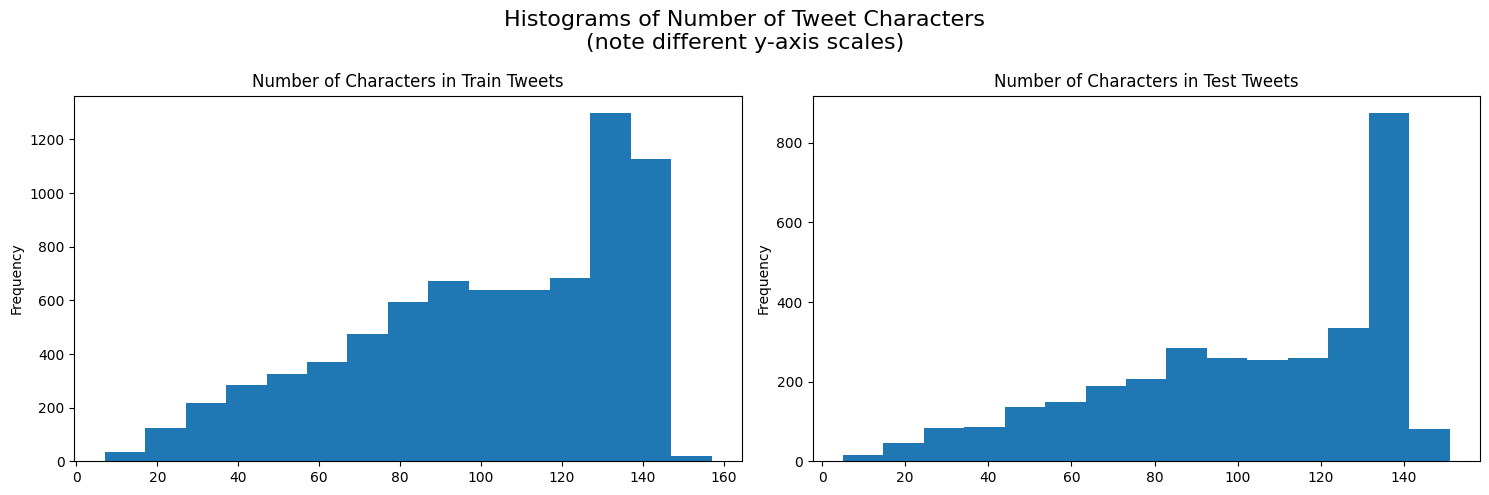

In [43]:
fig, axes = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(15, 5)
)

tweet_num_chars_train.plot(
    kind='hist'
    , ax=axes[0]
    , bins=15
);
axes[0].set_title('Number of Characters in Train Tweets')

tweet_num_chars_test.plot(
    kind='hist'
    , ax=axes[1]
    , bins=15
);
axes[1].set_title('Number of Characters in Test Tweets')
fig.suptitle('Histograms of Number of Tweet Characters\n(note different y-axis scales)', fontsize=16)
plt.tight_layout()

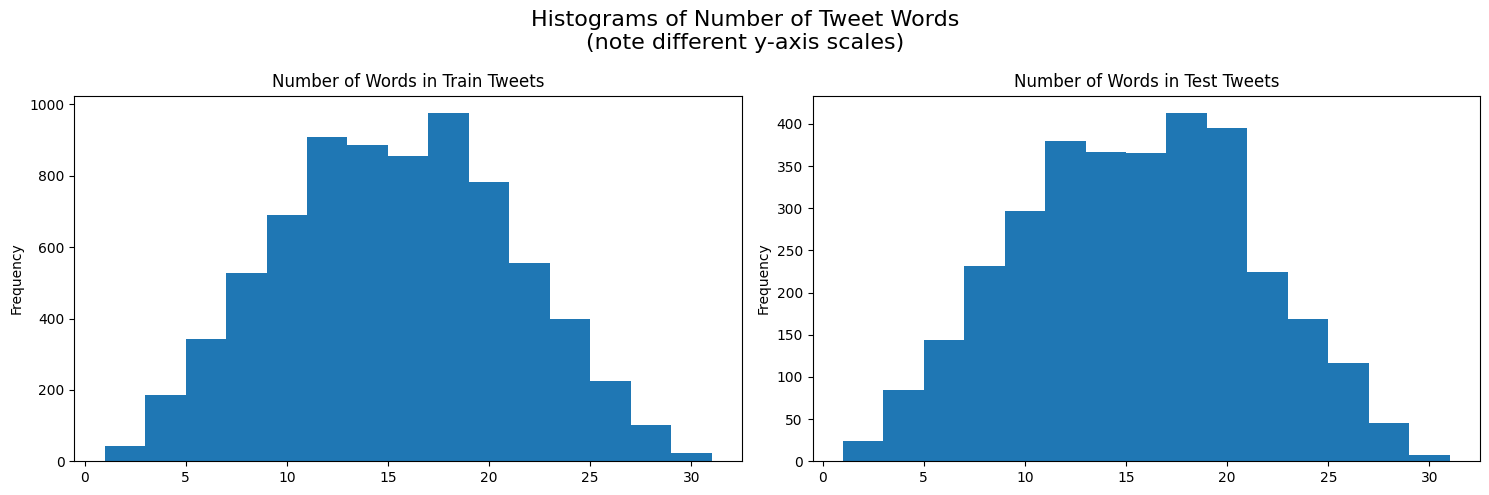

In [44]:
fig, axes = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(15, 5)
)

tweet_num_words_train.plot(
    kind='hist'
    , ax=axes[0]
    , bins=15
);
axes[0].set_title('Number of Words in Train Tweets')

tweet_num_words_test.plot(
    kind='hist'
    , ax=axes[1]
    , bins=15
);
axes[1].set_title('Number of Words in Test Tweets')

fig.suptitle('Histograms of Number of Tweet Words\n(note different y-axis scales)', fontsize=16)
plt.tight_layout()

The top pair of histograms shows character counts, and the bottom pair shows word counts. Similar to the stats just above, the distributions between train and test look similar, so we do not need to account for dissimilar distributions.

Similar to what we saw with locations, the quality of tweet text is pretty variable. Some are even hard to understand when manually skimming through them. It is not yet clear what, if any, extra preprocessing we may need to apply to the text feature. For instance, depending on the needs of modeling, we may want to clean up special characters, remove hyperlinks, try to identify quotes based on patterns of blocks of text between double quotes with what looks like one to three words after for names, etc. We also would need to try and identify outliers. There are so many variations though that this also may not be the best use of time in this iteration.
 
My preference is to do some modeling with the text feature as is. We can always return to cleaning this feature up if we run into problems with modeling or in future iterations as extra testing on how to continue improving modeling performance. But, for now, we will leave the remaining cleanup of the text feature for a later time.

Finally, we will take a look at the target feature, primarily looking for class balance.

Percentage of 0 labels: 0.574
Percentage of 1 labels: 0.426



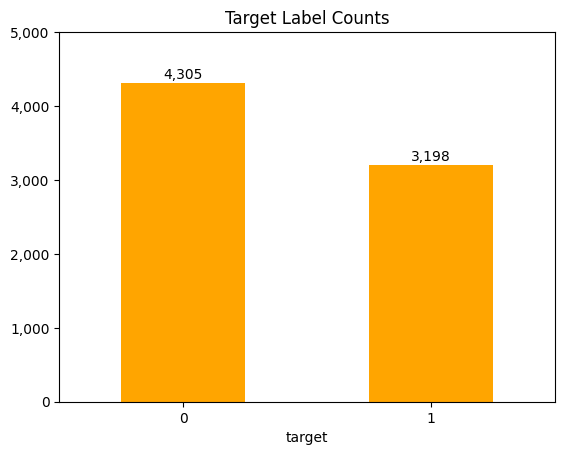

In [45]:
label_counts = df_train.groupby('target').count().iloc[:,0]
zeros = label_counts[0]
ones = label_counts[1]

print(f'Percentage of 0 labels: {zeros/(zeros+ones):.3f}')
print(f'Percentage of 1 labels: {ones/(zeros+ones):.3f}')
print()

ax = label_counts.plot(
    kind='bar'
    , rot=0
    , legend=False
    , color='orange'
    , title='Target Label Counts'
);

ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=1
);

# matplotlib throws a warning if you do not set the axis label values before then 
# reformatting the labels, so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

It looks like we have a 60-40 split between 0s (not a real disaster) and 1s (is a real disaster). I feel fine with this split, though it is an area we could circle back to in future modeling iterations to adjust to a 50-50 split to see if that affects model performance.

With that, I think we have the dataset ready to start exploring modeling. We noted a few areas where we may want to return during this iteration of the project or in future iterations. For now, we will let modeling guide us on if we need to return to anything above, and, in order to do that, we need to pivot to the modeling itself.

With one more stop along the way.

## Word Embeddings

We are not quite done with preprocessing. The final piece we need is to implement word embeddings. Machine learning models cannot work with raw text, so we need to convert text to numbers in matrix form.

It helps me to think of arriving at word embeddings as a step along the process of turning text into numeric representations. We will walk through this for the `text` feature, but we also need a strategy for including `keyword`.

To start out, we will walk through the bag-of-words approach.

We could one-hot encode all the words in all the tweets. We would have a big sparse matrix with one feature for each word that shows up across all the tweets. This feature space would be the entire vocabulary we are working with across all the tweets combined. The initial encoding here is not helpful since it is unclear what each row represents. We can improve this by defining each row as one tweet. Instead of a one-hot encoded matrix, we now use 1s to indicate each word that shows up in a tweet. The matrix will still be very sparse due to having around 10-20 words per tweet on average, a small portion of the total number of unique words in the combined vocabulary. So, while we are still working with a matrix that is sparse enough to be problematic, we have found a foothold for representing tweets as numeric vectors in a way that makes some sense.

For the next improvement, we need to address that the previous step leaves us with boolean flags indicating if a word exists in a tweet, but there is no context for those words. A next step could be to change the 1s and 0s for boolean indicators to counts. We would keep the same sparsity in the matrix, but we would now have a little more info related to how often each word shows up in a tweet. For example, the model may use counts to determine that if the word "fire" shows up once or twice in a tweet, then it is more likely related to an actual disaster, but, if "fire" shows up more often, then it does not correlate with a real disaster.

The bag-of-words models are missing one major piece of information we need: context. We do not know which words show up near each other, so we lose the ability to process phrases. We do not include overall tweet length, so the model may not distinguish between words showing up more often due to longer tweet length compared to words showing up more indicating more importance on those words. We can add in our next improvement by dividing each count by the total number of words in a tweet, resulting in a text frequency (TF).

While this is a step up from raw counts, we still have the issue that some words in the English language are more common than others. For example, "the" and "a" will likely show up with higher TF than other words, those other words being more important for identifying real disasters. To adjust for this, we can multiply the TF by the inverse of the amount of tweets in which a given word shows up, the inverse document frequency (IDF). The result of multiplying the TF by the IDF gives us a TFIDF value. If a word shows up in lots of tweets, then it will have a low IDF, so, when we multiply the TF by the IDF, the resulting value is lower. In contrast, if a word shows up in fewer tweets, then multiplying by the IDF results in a higher value. The way I understand this is that words that are too common across tweets are not useful for distinguishing between those tweets. We want to isolate less frequent words in the hopes that those will provide stronger signals for the meaning of tweets.

We will stick with TFIDF for this project. I originally planned to keep moving on to Word2Vec, a more complicated algorithm for converting text to numbers that captures context and relationships in the text or global vectors for word representation (GloVe), an embedding algorithm that focuses on co-occurrence of words. But, I am now leaning towards keeping the word embeddings step simpler in order to remain focused on the RNN modeling coming up.


## Modeling

We will use RNNs for modeling.

- RNNs work with sequences
- Clarify what sequences are
- Point out what is different with RNNs and sequences compared to MLPs or CNNs
- Passing outputs back in as inputs
- How to retain context or history of inputs
- Variable input and output lengths
- Lots of flexibility with RNNs, so how do we keep that complexity constrained and focused on the project goals
- Other models have fixed inputs and outputs that we know ahead of time
- LSTMs
- LSTMs add more complexity to incorporating previous information than in standard RNNs
- This project is a many-to-one RNN architecture
- Talk about how we could include the embedding matrix as part of the RNN or can pass an embedding matrix in as input
- RNNs also have a weight matrix for hidden layer to hidden layer that we add to the next input layer
- Backpropagation through time
- Binary classification
- Focusing on text feature first, though we have keyword queued up to add into the model

In [20]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train['text']
    , df_train['target']
    , test_size=0.2
    , random_state=8675309
)

x_test = df_test['text']

In [21]:
# Utility function that takes in an np.array() of prediction probabilities
# and saves them to a CSV with 0 and 1 lables for competition submission
def gimme_preds(predictions, name):
    pd.DataFrame({
        'id': df_test['id']
        , 'target': np.where(predictions >= 0.5, 1, 0)
    }).to_csv(f'{out_dir}/preds_{name}.csv', index=False)

In [22]:
def gimme_plots(history):
    fig, axes = plt.subplots(
        1
        , 2
        , figsize=(20,10)
    )

    # Note that epochs are offset by one due to zero indexing
    axes[0].plot(history.history['f1_score'], label='f1_score');
    axes[0].plot(history.history['val_f1_score'], label='val_f1_score');
    axes[0].set_xlabel('epoch');
    axes[0].set_ylabel('auc');
    axes[0].set_ylim([0, 1]);
    axes[0].legend(loc='lower right');
    axes[0].set_title('AUC vs Epoch 0-1 Scale');

    axes[1].plot(history.history['f1_score'], label='f1_score');
    axes[1].plot(history.history['val_f1_score'], label='val_f1_score');
    axes[1].set_xlabel('epoch');
    axes[1].set_ylabel('auc');
    axes[1].legend(loc='lower right');
    axes[1].set_title('AUC vs Epoch Zoomed-In Scale');

In [23]:
epochs = 5
optimizer = 'adam'
loss = 'binary_crossentropy'
metric = 'f1_score'

# The epochs param lets us train with a consistent and higher number
# of epochs but then pass in specific numbers for each model based
# on what we find during hyperparameter tuning
def gimme_models(name, model, epochs=epochs):
    model.summary()

    model.compile(
        optimizer=optimizer
        , loss=loss
        , metrics=[metric]
    )

    hist = model.fit(
        x=x_train
        , y=y_train
        , epochs=epochs
        , validation_data=(x_val, y_val)
    )

    gimme_plots(hist)

    preds = model.predict(
        x_test
        , verbose=2
    )

    gimme_preds(preds, name)

In [24]:
bow_vectorizer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation'
    , split='whitespace'
    , output_mode='count'
)
encoder.adapt(x_train)

tfidf_vectorizer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation'
    , split='whitespace'
    , output_mode='tf_idf'
)
encoder.adapt(x_train)


In [25]:
encoder.vocabulary_size()

17238

In [26]:
# gimme_models(
#     'lstm_01'
#     , models.Sequential([
#         tfidf_vectorizer
#         , layers.Embedding(
#             input_dim=encoder.vocabulary_size()
#             , output_dim=64 # Can adjust to balance overfitting with losing information from the embeddings
#         )
#         , layers.Bidirectional(layers.LSTM(64, activation='tanh'))
#         , layers.Dense(64, activation='relu')
#         , layers.Dense(1, activation='sigmoid')
#     ])
#     , 1
# )

In [27]:
# gimme_models(
#     'gru_01'
#     , models.Sequential([
#         tfidf_vectorizer
#         , layers.Embedding(
#             input_dim=encoder.vocabulary_size()
#             , output_dim=64 # Can adjust to balance overfitting with losing information from the embeddings
#         )
#         , layers.Bidirectional(layers.GRU(64, activation='tanh'))
#         , layers.Dense(64, activation='relu')
#         , layers.Dense(1, activation='sigmoid')
#     ])
#     , 1
# )

In [28]:
rnn = models.Sequential([
    tfidf_vectorizer
    , layers.Embedding(
        input_dim=tfidf_vectorizer.vocabulary_size()
        , output_dim=64 # Can adjust to balance overfitting with losing information from the embeddings
    )
    , layers.Bidirectional(layers.GRU(64, activation='tanh'))
    , layers.Dense(64, activation='relu')
    , layers.Dense(1, activation='sigmoid')
])

rnn.summary()

rnn.compile(
    optimizer=optimizer
    , loss=loss
    , metrics=[metric]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
hist = rnn.fit(
    x=x_train
    , y=y_train
    , epochs=1
    , validation_data=(x_val, y_val)
)

168/168 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - f1_score: 0.5888 - loss: 0.6810 - val_f1_score: 0.5788 - val_loss: 0.7014


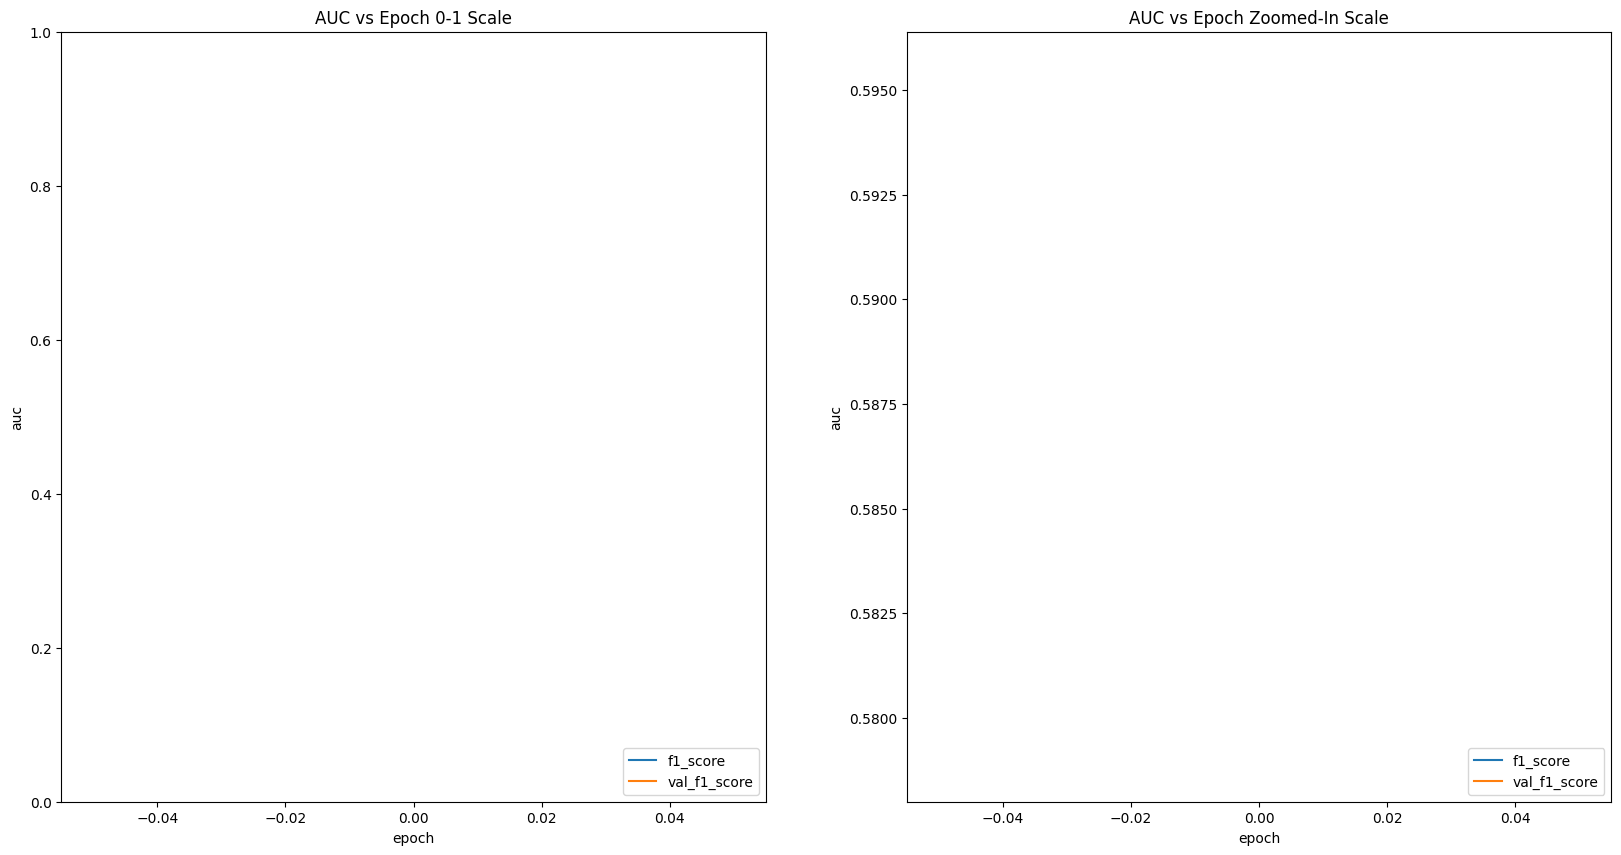

In [31]:
history = hist

fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

# Note that epochs are offset by one due to zero indexing
axes[0].plot(history.history['f1_score'], label='f1_score');
axes[0].plot(history.history['val_f1_score'], label='val_f1_score');
axes[0].set_xlabel('epoch');
axes[0].set_ylabel('auc');
axes[0].set_ylim([0, 1]);
axes[0].legend(loc='lower right');
axes[0].set_title('AUC vs Epoch 0-1 Scale');

axes[1].plot(history.history['f1_score'], label='f1_score');
axes[1].plot(history.history['val_f1_score'], label='val_f1_score');
axes[1].set_xlabel('epoch');
axes[1].set_ylabel('auc');
axes[1].legend(loc='lower right');
axes[1].set_title('AUC vs Epoch Zoomed-In Scale');

In [32]:
preds = rnn.predict(
        x_test
        , verbose=2
    )

90/90 - 48s - 537ms/step


In [38]:
# preds
# np.where(preds >= 0.5, 1, 0)



pd.DataFrame({
    'id': df_test['id']
    , 'target': np.where(preds >= 0.5, 1, 0).reshape(-1,)
}).to_csv(f'{out_dir}/preds_gru_test.csv', index=False)

## Modeling Results and Summary

## Conclusion

## References

RNNs:
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://karpathy.github.io/2015/05/21/rnn-effectiveness/
- https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

Good ol' Wikipedia starting points for NLP topics:
- https://en.wikipedia.org/wiki/Document_classification 
- https://en.wikipedia.org/wiki/Feature_(machine_learning)#Feature_vectors
- https://en.wikipedia.org/wiki/Word_embedding
- https://en.wikipedia.org/wiki/Bag-of-words_model
- https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- https://en.wikipedia.org/wiki/Word2vec
- https://en.wikipedia.org/wiki/Stop_word
- https://en.wikipedia.org/wiki/Self-supervised_learning

Global Vectors for Word Representation (GloVe): 
- https://nlp.stanford.edu/projects/glove/
- https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/

Readings on turning text into vectors:
- https://towardsdatascience.com/how-to-turn-text-into-features-478b57632e99

Tensorflow docs:
- https://www.tensorflow.org/text/tutorials/word2vec
- https://www.tensorflow.org/text/tutorials/text_classification_rnn
- https://www.tensorflow.org/text/guide/word_embeddings
- https://www.tensorflow.org/guide/keras/working_with_rnns

Word2Vec and word embeddings:
- https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381

Videos:
- https://www.youtube.com/watch?v=TI4HRR3Hd9A
- https://www.youtube.com/watch?v=0XdPIqi0qpg
